In [209]:
import asyncio
import requests

from kinopoisk_dev import KinopoiskDev, ReviewField, ReviewParams
from kinopoisk_dev.model import ReviewDocsResponseDto

import pandas as pd

In [210]:
FastTextSocialNetworkModel.MODEL_PATH = 'fasttext-social-network-model.bin'
model = FastTextSocialNetworkModel(tokenizer=tokenizer)

In [211]:
def get_movie_id_by_name(name, page = 1, limit = 1):
    headers = {"X-API-KEY": TOKEN}
    response = requests.get(
        'https://api.kinopoisk.dev/v1.4/movie/search',
        params={
            "query": name,
            "limit": limit,
            "page": page,
        },
        headers=headers
    )
    movie = response.json()
    return movie["docs"][0]['id']

In [212]:
def get_reviews(movie_id, limit):
    kp = KinopoiskDev(token=TOKEN)
    item = kp.review(
        params=[
            ReviewParams(keys=ReviewField.MOVIE_ID, value=movie_id),
            ReviewParams(keys=ReviewField.LIMIT, value=limit)
        ]
    )
    return item

In [213]:
movies_250 = list(map(lambda movie: movie.strip(), list(pd.read_csv('kinopoisk-top250.csv')["movie"])[:5]))
movies_250

['Побег из Шоушенка', 'Зеленая миля', 'Форрест Гамп', 'Список Шиндлера', '1+1']

In [214]:
reviews = {}

In [215]:
for movie in movies_250:
    movie_id = get_movie_id_by_name(movie)
    reviews[movie] = get_reviews(movie_id, 100)

In [216]:
from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel

tokenizer = RegexTokenizer()
model = FastTextSocialNetworkModel(tokenizer=tokenizer)

In [265]:
df = pd.DataFrame({'movie_id' : [], 'movie_name' : [], 
                   'review_id': [], 'review_title' : [], 'review_text' : [], 
                   'positive' : [], 'negative' : [], 'neutral' : [],
                   'Dostoevsky-eval': [], 'kinopoisk-eval' : [], 'date' : []})

In [267]:
for movie in movies_250:
    for review in reviews[movie].docs:
        text = review.review
        results = model.predict([text], k=5)[0]
        new_line = [review.movieId, movie, 
                    review.id, review.title, review.review, 
                    results['positive'], results['negative'], results['neutral'], 
                    'positive' if results['positive'] > results['negative'] and results['positive'] > results['neutral'] else 
                    'negative' if results['negative'] > results['neutral'] else
                    'neutral',
                    review.type, review.date]
        df.loc[len(df.index)] = new_line
df['date'] = pd.to_datetime(df['date'])

In [268]:
df.head()

,movie_id,movie_name,review_id,review_title,review_text,positive,negative,neutral,Dostoevsky-eval,kinopoisk-eval,date
0,326,Побег из Шоушенка,3301672,НЕправосудие,Как часто люди сталкиваются с правосудием? Как...,0.164526,0.156115,0.430157,neutral,Позитивный,2023-09-24T16:47:42.000Z
1,326,Побег из Шоушенка,3304191,Жажда свободы,'Побег из Шоушенка' – фильм о классической ист...,0.201823,0.156115,0.392347,neutral,Позитивный,2023-10-02T12:35:24.000Z
2,326,Побег из Шоушенка,3324223,Главным героем всё это время был не Энди Дюфрейн,"Говоря про фильм «Побег из Шоушенка», то я все...",0.136618,0.217348,0.422515,neutral,Позитивный,2023-11-27T14:03:07.000Z
3,326,Побег из Шоушенка,3289333,"Свобода, она такая.",Неразлучная парочка 'рабство-свобода' привлека...,0.156115,0.217348,0.453272,neutral,Нейтральный,2023-08-19T10:55:13.000Z
4,326,Побег из Шоушенка,3274753,Околозаконное рабство.,"Да-да, 'Зелёная миля', 'Побег из Шоушенка' и '...",0.245095,0.228166,0.287778,neutral,Позитивный,2023-07-03T12:53:45.000Z


In [269]:
df.to_csv('movies.csv')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


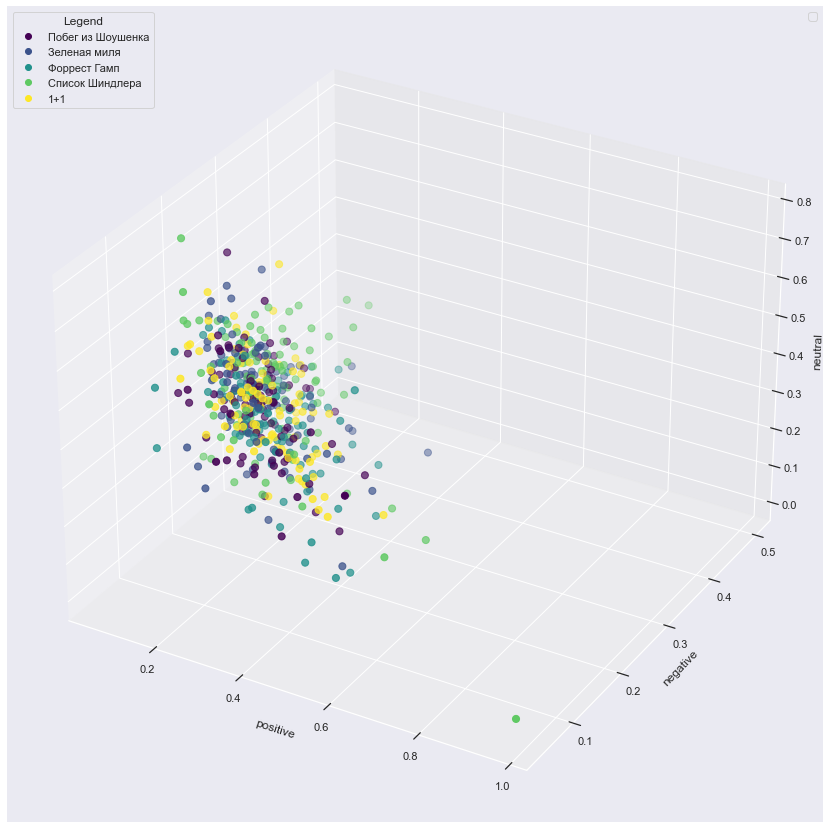

In [270]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection = '3d')

x = df['positive']
y = df['negative']
z = df['neutral']

ax.set_xlabel("positive")
ax.set_ylabel("negative")
ax.set_zlabel("neutral")

colors = list(map(lambda x: movies_250.index(x)+1, np.array(df['movie_name'])))

scatter = ax.scatter3D(x, y, z, s=50, c=colors, cmap='viridis')
legend = ax.legend(*[scatter.legend_elements()[0], movies_250], 
                    title="Legend", loc='upper left')
ax.add_artist(legend)

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


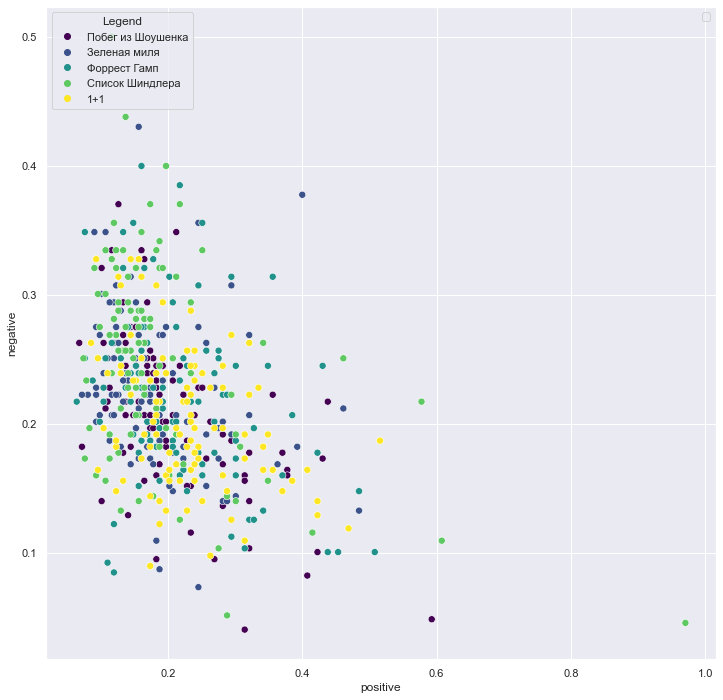

In [271]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot()

sns.scatterplot(data=df, x="positive", y="negative", s=50, c=colors, cmap='viridis')
legend = ax.legend(*[scatter.legend_elements()[0], movies_250], 
                    title="Legend", loc='upper left')
ax.add_artist(legend)

plt.legend()
plt.show()

In [272]:
average_values = df.groupby(['movie_name'])[['positive', 'negative', 'neutral']].mean().reset_index()
average_values

,movie_name,positive,negative,neutral
0,1+1,0.226758,0.203070,0.360074
1,Зеленая миля,0.186600,0.226459,0.349493
2,Побег из Шоушенка,0.207599,0.206819,0.350564
3,Список Шиндлера,0.186987,0.249228,0.353006
4,Форрест Гамп,0.219559,0.220203,0.306792


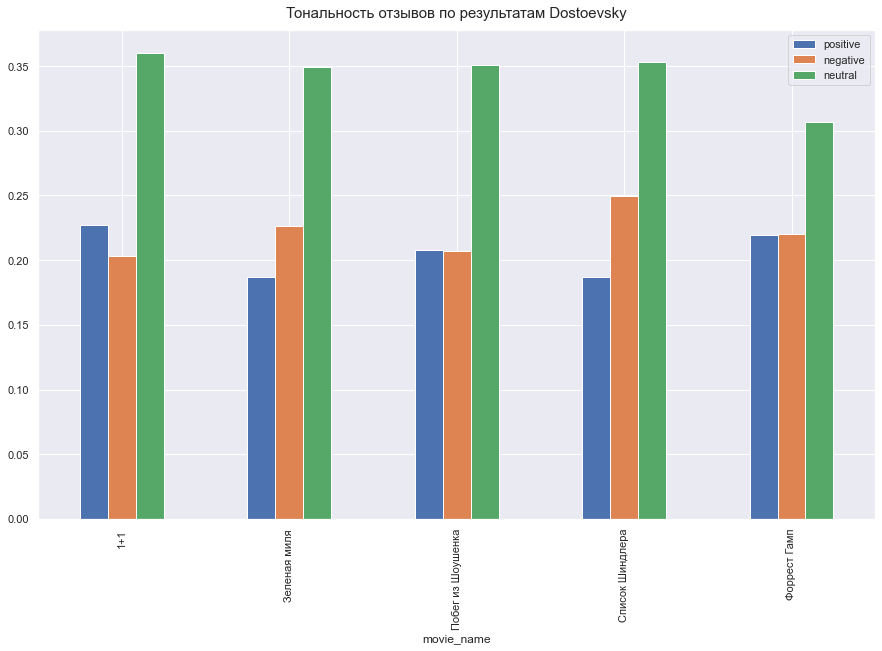

In [239]:
plot = average_values.plot(x="movie_name", y=["positive", "negative", "neutral"], kind="bar")
plot.set_title('Тональность отзывов по результатам Dostoevsky', fontdict={'fontsize':15}, pad=12)
plt.show()

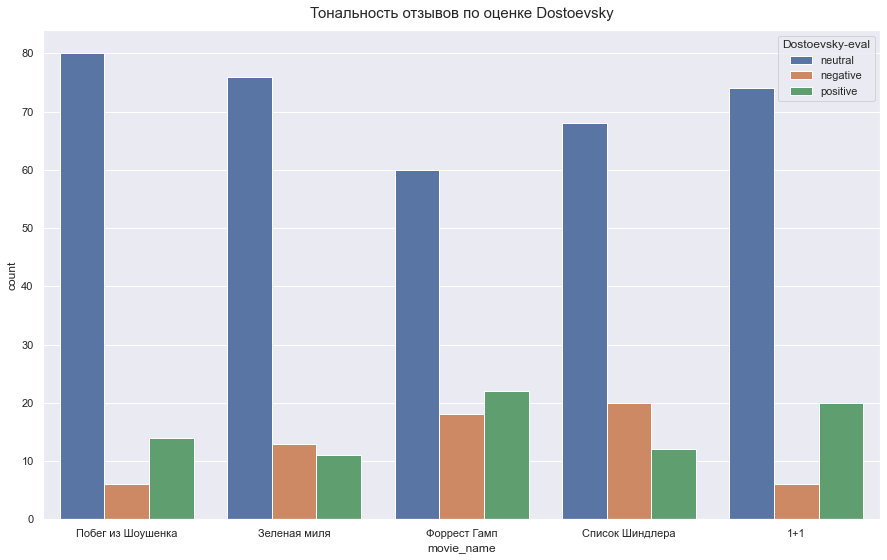

In [273]:
sns.set(rc={'figure.figsize':(15,9)})
plot = sns.countplot(x="movie_name", hue="Dostoevsky-eval", data=df)
plot.set_title('Тональность отзывов по оценке Dostoevsky', fontdict={'fontsize':15}, pad=12)
plt.show()

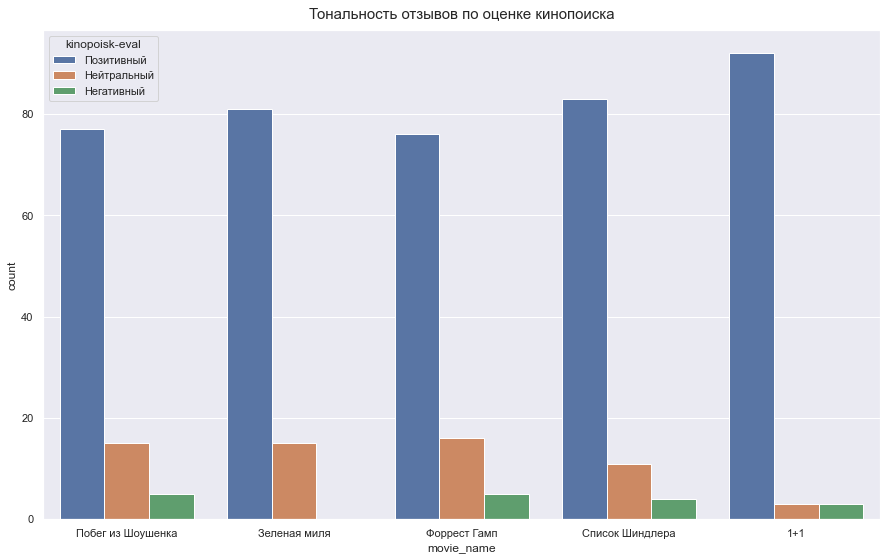

In [240]:
sns.set(rc={'figure.figsize':(15,9)})
plot = sns.countplot(x="movie_name", hue="kinopoisk-eval", data=df)
plot.set_title('Тональность отзывов по оценке кинопоиска', fontdict={'fontsize':15}, pad=12)
plt.show()

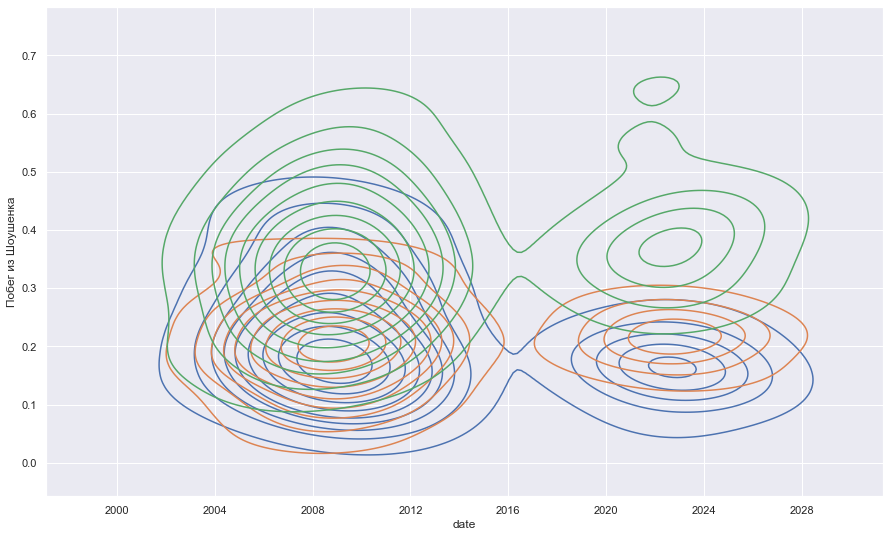

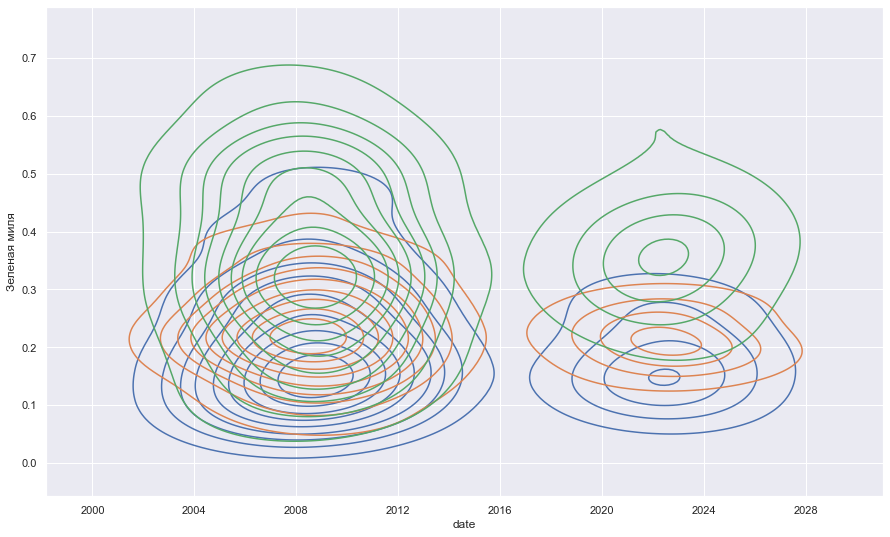

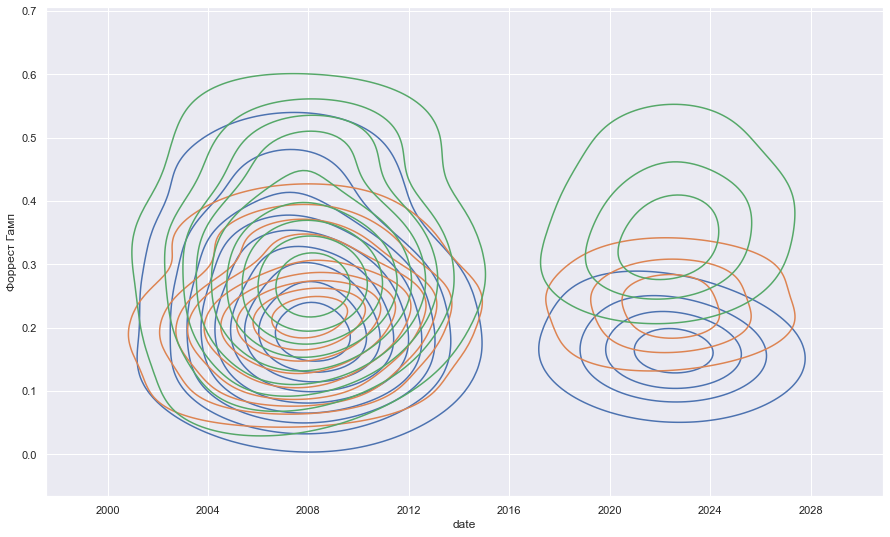

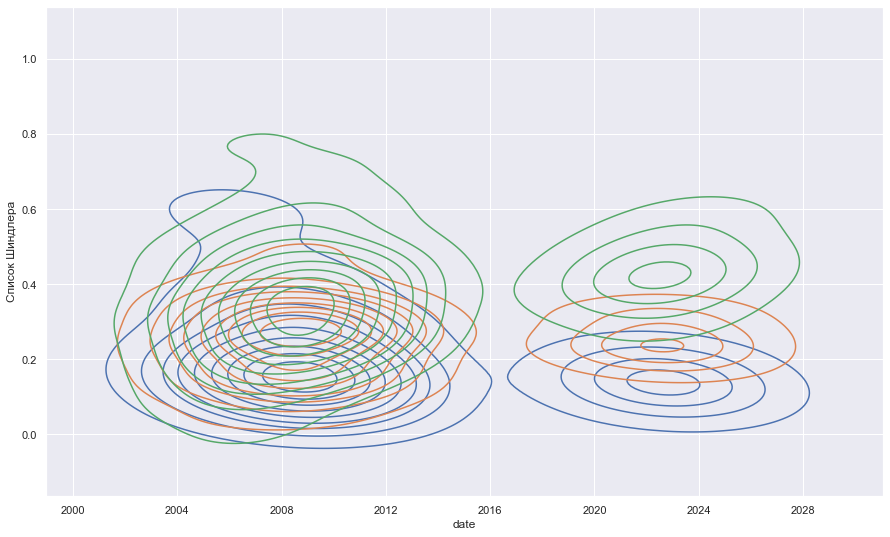

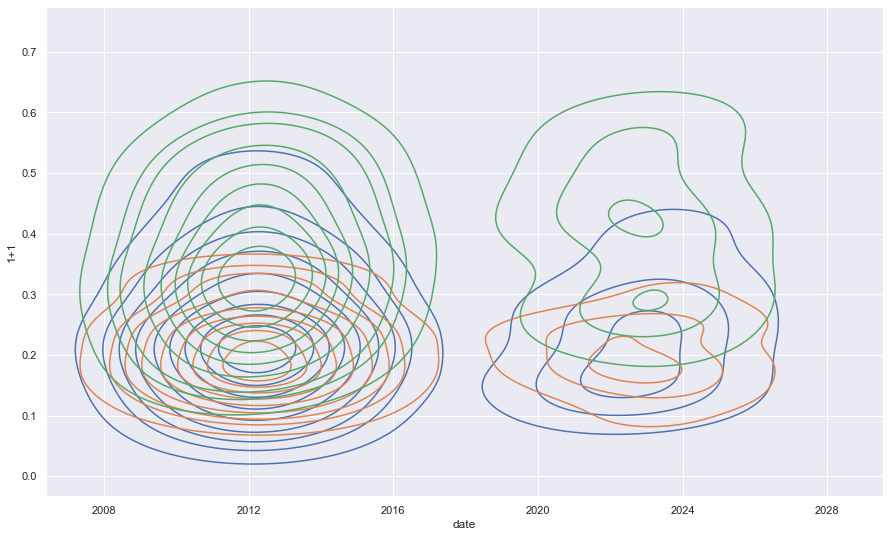

In [262]:
for movie in movies_250:
    sns.kdeplot(x = "date", y = "positive", data = df[df["movie_name"] == movie]) 
    sns.kdeplot(x = "date", y = "negative", data = df[df["movie_name"] == movie]) 
    sns.kdeplot(x = "date", y = "neutral", data = df[df["movie_name"] == movie]) 
    plt.ylabel(movie) 
    plt.xticks()
    plt.show()